# Table of contents

[Bivariate linear regression model](#bi_regression)

[Multivariate linear regression model](#multi_regression)


In [1047]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import fine_time_coupling_samples
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import allensdk
import h5py
import pynwb
import hdmf
import matplotlib
print('pd', pd.__version__)
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.3.2


# Bivariate generator + bivariate regression model <a name="bi_regression"></a>

In [174]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
jittertool = jitter.JitterTool()

num_iters = 50
spk_bin_width = 0.002
jitter_window_width = 0.02
link_func = 'linear'

beta = np.zeros([num_iters, 2])
p_values = np.zeros(num_iters)
for itr in tqdm(range(num_iters), ncols=100):
#     num_peaks, sigma = 40, 0.04
#     spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
#             trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
#     spike_times_x = spike_times[:num_trials]
#     spike_times_y = spike_times[num_trials:]
#     spike_times_multi = [0, 0]
    lmbd = 20
    spike_times_x = generator.generate_poisson_spike_times(lmbd, trial_length, num_trials=num_trials)
    spike_times_y = generator.generate_poisson_spike_times(lmbd, trial_length, num_trials=num_trials)

    # synchrony_rate = 0.4
    # spike_times_multi[0], spike_times_multi[1] = generator.inject_synchrony_to_spike_times(
    #     spike_times_x, spike_times_y, synchrony_rate, trial_length)
    synchrony_prob = 0.01
    spike_times_multi[0], spike_times_multi[1] = generator.inject_prob_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_prob, trial_length)

    mean_correct_type = 'binary'
    distribution_type='binom'
    binarize = True
    p_values[itr], beta[itr,0] = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_multi[0], spike_times_multi[1], spk_bin_width, trial_length,
        jitter_window_width, link_func, distribution_type, mean_correct_type=mean_correct_type,
        binarize=binarize, ci_alpha=0.05, verbose=False)

    jitter_type = 'interval_binary'
    basis_type = 'B0B1'
    beta1 = jittertool.bivariate_spike_hist_coupling_filter_regression(
        spike_times_multi[0], spike_times_multi[1], trial_length, spk_bin_width, jitter_window_width,
        jitter_type, basis_type, link_func=link_func, epsilon=1e-9)
    delta = int(jitter_window_width / spk_bin_width)
    beta[itr,1] = beta1[1,0] * (delta-1) / delta


100%|███████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.27it/s]


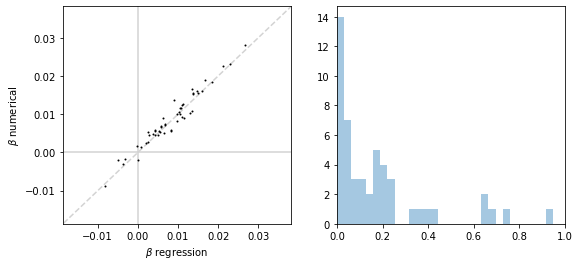

In [176]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.axvline(x=0, c='lightgrey')
plt.axhline(y=0, c='lightgrey')
plt.plot([-1, 1], [-1, 1], ls='--', c='lightgrey')

plt.plot(beta[:,1], beta[:,0], 'k.', ms=2)
val_min = np.min(beta)
val_max = np.max(beta)
margin = 0.01
plt.axis([val_min-margin, val_max+margin, val_min-margin, val_max+margin])
plt.xlabel(r'$\beta$ regression')
plt.ylabel(r'$\beta$ numerical')

plt.subplot(122)
seaborn.distplot(p_values, bins=30, kde=False)
plt.xlim(0, 1)
plt.show()

# Generate multivariate point process with sync.

#### Poisson process.

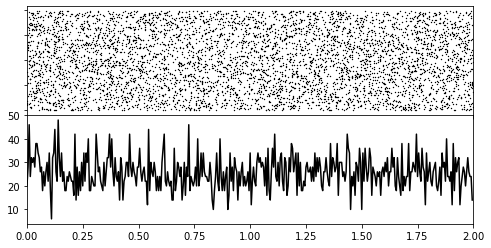

In [615]:
num_nodes = 3
# lmbd = 20
lmbd = [2, 25, 25]
trial_length = 2
num_trials = 100
sync_prob_mat = np.array([[0,0.01, 0.01], [0.01,0,0], [0.01,0,0]])
# sync_prob_mat = np.array([[0,0,0], [0,0,0], [0,0,0]])
spike_times_multi = generator.generate_poisson_spike_times_multi_sync(lmbd, trial_length, num_nodes, num_trials, 
        sync_prob_mat=sync_prob_mat, sync_rate_mat=None, verbose=True)


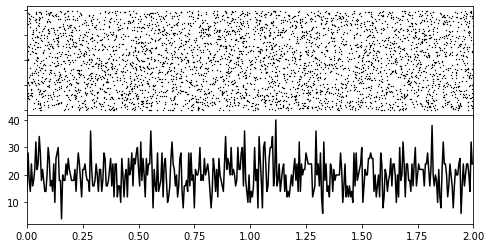

In [611]:
sync_rate_mat = np.array([[0,0.1, 0.1], [0.1,0,0], [0.1,0,0]])
spike_times_multi = generator.generate_poisson_spike_times_multi_sync(lmbd, trial_length, num_nodes, num_trials, 
        sync_prob_mat=None, sync_rate_mat=sync_rate_mat, verbose=True)


In [599]:
spike_times_multi

#### Amarasingham process.

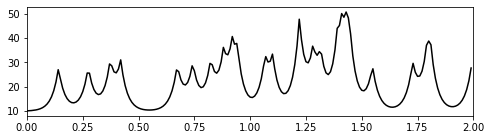

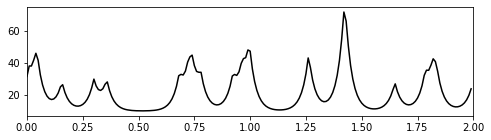

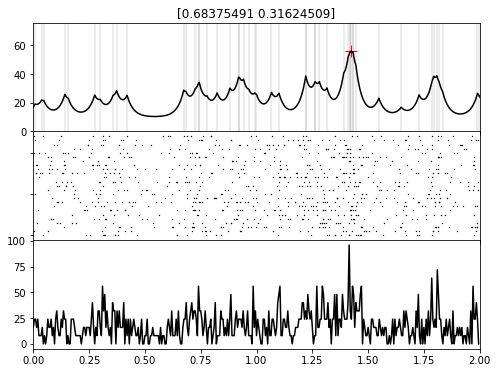

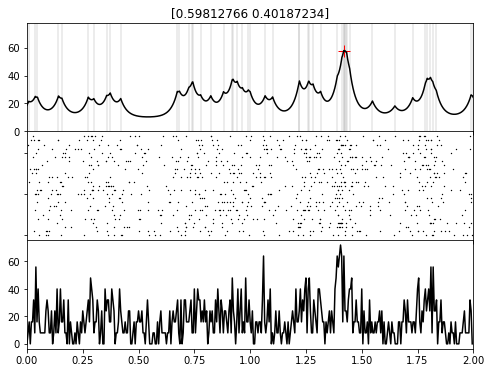

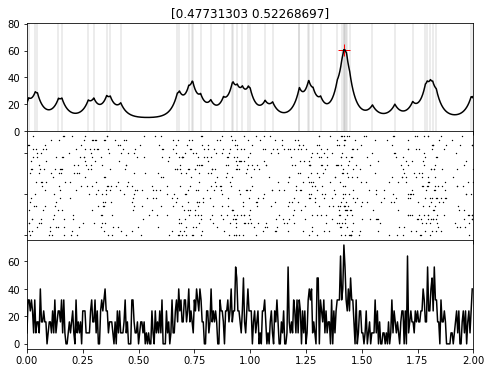

In [425]:
num_peaks, sigma = 15, 0.04
num_nodes = 3
trial_length = 2
num_trials = 25

num_drivers = 2
sync_prob_mat = np.array([[0,0.01, 0.01], [0.01,0,0], [0.01,0,0]])
# sync_prob_mat = np.array([[0,0,0], [0,0,0], [0,0,0]])

spike_times_multi = generator.generate_amarasingham_spike_times_multi_sync(num_peaks, sigma,
        trial_length, num_nodes, num_trials, num_drivers, sync_prob_mat, sample_type='density', verbose=True)


In [ ]:
sync_rate_mat = np.array([[0,0.1, 0.1], [0.1,0,0], [0.1,0,0]])
spike_times_multi = generator.generate_amarasingham_spike_times_multi_sync(num_peaks, sigma,
        trial_length, num_nodes, num_trials, num_drivers, 
        sync_prob_mat=None, sync_rate_mat=sync_rate_mat, sample_type='density', verbose=True)


In [ ]:
spike_times_multi

#### create_sync_prob_mat

In [602]:
jittertool = jitter.JitterTool()
mat = jittertool.create_sync_prob_mat(4, [0,0]); print(mat)
mat = jittertool.create_sync_prob_mat(4, [1,1]); print(mat)
mat = jittertool.create_sync_prob_mat(4, [0.5,0.6]); print(mat)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]
[[0.         0.50734856 0.55432743 0.56108426]
 [0.50734856 0.         0.56922159 0.53105747]
 [0.55432743 0.56922159 0.         0.57714356]
 [0.56108426 0.53105747 0.57714356 0.        ]]


# Marginal regression.

In [576]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
jittertool = jitter.JitterTool()

# np.random.seed(2)

num_iters = 20
spk_bin_width = 0.002
jitter_window_width = 0.02
link_func = 'linear'

beta = np.zeros([num_iters, 2])
p_values = np.zeros(num_iters)
for itr in tqdm(range(num_iters), ncols=100):
    num_nodes = 3
    trial_length = 2
    num_trials = 25
#     sync_prob_mat = np.array([[0,0.01, 0.01], [0.01,0,0], [0.01,0,0]])
    # sync_prob_mat = np.array([[0,0,0], [0,0,0], [0,0,0]])
    sync_rate_mat = np.array([[0,0.2, 0.2], [0.2,0,0], [0.2,0,0]])
    
#     lmbd = 20
#     spike_times_multi = generator.generate_poisson_spike_times_multi_sync(lmbd, trial_length, num_nodes, num_trials, sync_prob_mat)
    num_drivers, num_peaks, sigma = 2, 15, 0.04
    spike_times_multi = generator.generate_amarasingham_spike_times_multi_sync(num_peaks, sigma, trial_length, num_nodes, num_trials, 
            num_drivers, sync_prob_mat=None, sync_rate_mat=sync_rate_mat, verbose=False)

    mean_correct_type = 'binary'
    distribution_type='binom'
    binarize = True
    p_values[itr], beta[itr,0] = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_multi[0], spike_times_multi[1], spk_bin_width, trial_length,
        jitter_window_width, link_func, distribution_type, mean_correct_type=mean_correct_type,
        binarize=binarize, ci_alpha=0.05, verbose=False)

    jitter_type = 'interval_binary'
    basis_type = 'B0B1'
    beta1 = jittertool.bivariate_spike_hist_coupling_filter_regression(
        spike_times_multi[0], spike_times_multi[1], trial_length, spk_bin_width, jitter_window_width,
        jitter_type, basis_type, link_func=link_func, epsilon=1e-9)
    delta = int(jitter_window_width / spk_bin_width)
    beta[itr,1] = beta1[1,0] * (delta-1) / delta


  5%|███▏                                                            | 1/20 [00:01<00:21,  1.12s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 10%|██████▍                                                         | 2/20 [00:02<00:21,  1.18s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 15%|█████████▌                                                      | 3/20 [00:03<00:19,  1.12s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 20%|████████████▊                                                   | 4/20 [00:04<00:17,  1.10s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 25%|████████████████                                                | 5/20 [00:05<00:16,  1.10s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 30%|███████████████████▏                                            | 6/20 [00:06<00:15,  1.11s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 35%|██████████████████████▍                                         | 7/20 [00:07<00:14,  1.12s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 40%|█████████████████████████▌                                      | 8/20 [00:08<00:13,  1.13s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 45%|████████████████████████████▊                                   | 9/20 [00:09<00:11,  1.09s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 50%|███████████████████████████████▌                               | 10/20 [00:11<00:11,  1.12s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 55%|██████████████████████████████████▋                            | 11/20 [00:12<00:10,  1.19s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 60%|█████████████████████████████████████▊                         | 12/20 [00:13<00:09,  1.22s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 65%|████████████████████████████████████████▉                      | 13/20 [00:14<00:08,  1.16s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 70%|████████████████████████████████████████████                   | 14/20 [00:15<00:06,  1.12s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 75%|███████████████████████████████████████████████▎               | 15/20 [00:17<00:05,  1.14s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 80%|██████████████████████████████████████████████████▍            | 16/20 [00:18<00:04,  1.13s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 85%|█████████████████████████████████████████████████████▌         | 17/20 [00:19<00:03,  1.13s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 90%|████████████████████████████████████████████████████████▋      | 18/20 [00:20<00:02,  1.08s/it]

0 1 0.2
0 2 0.2
1 2 0.0


 95%|███████████████████████████████████████████████████████████▊   | 19/20 [00:21<00:01,  1.16s/it]

0 1 0.2
0 2 0.2
1 2 0.0


100%|███████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]

0 1 0.2
0 2 0.2
1 2 0.0


(0.0, 1.0)

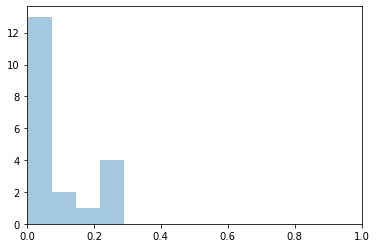

In [577]:
seaborn.distplot(p_values, kde=False)
plt.xlim(0, 1)

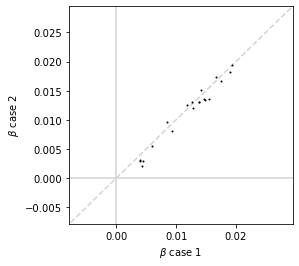

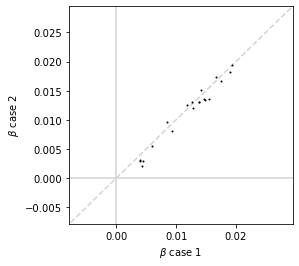

In [578]:
jittertool.plot_beta_comparison(beta, separate=False)
jittertool.plot_beta_comparison(beta, separate=True)

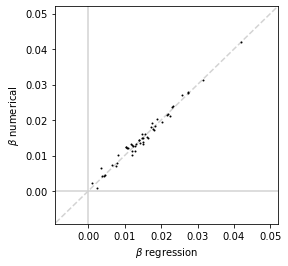

In [428]:
# Amarasingham task.

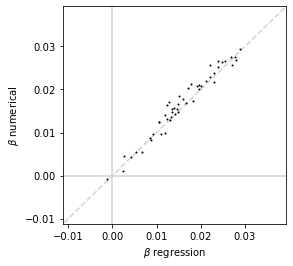

In [185]:
# Poisson task.

(0.0, 1.0)

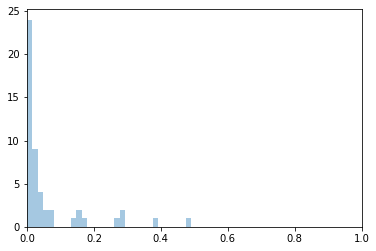

In [429]:
seaborn.distplot(p_values, bins=30, kde=False)
plt.xlim(0, 1)

# Partial regression.

In [848]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
jittertool = jitter.JitterTool()

# np.random.seed(2)

num_iters = 100
spk_bin_width = 0.002
jitter_window_width = 0.02
num_nodes = 3

beta = np.zeros([num_iters, 2, num_nodes-1])
p_values = np.zeros(num_iters)

for itr in tqdm(range(num_iters), ncols=100):
# for itr in range(num_iters):
    trial_length = 2
    num_trials = 25
#     sync_prob_mat = np.array([[0,0.01,0.01], [0.01,0,0], [0.01,0,0]])
    # sync_prob_mat = np.array([[0,0,0], [0,0,0], [0,0,0]])
    sync_prob_mat = np.array([[0,0,0], [0,0,0], [1,1,0]])
#     sync_prob_mat = np.array([[0,0,0.95], [0,0,0.95], [0.95,0.95,0]])

    lmbd = [25, 25, 0.4]
    spike_times_multi = generator.generate_poisson_spike_times_multi_sync(lmbd, trial_length, num_nodes, num_trials,
        sync_prob_mat=sync_prob_mat, sync_rate_mat=None, verbose=False)
#     num_drivers, num_peaks, sigma = 2, 15, 0.04
#     spike_times_multi = generator.generate_amarasingham_spike_times_multi_sync(num_peaks, sigma, trial_length, num_nodes, num_trials, 
#         num_drivers, sync_prob_mat=sync_prob_mat, sync_rate_mat=None, sample_type='density', verbose=False)

    jitter_type = 'interval'
    basis_type = 'B1'
    link_func = 'linear'
    beta_tmp = jittertool.multivariate_spike_hist_coupling_filter_regression(
        spike_times_multi[1:2], spike_times_multi[0], trial_length, spk_bin_width, jitter_window_width,
        jitter_type, basis_type, link_func=link_func, epsilon=1e-9)
    delta = int(jitter_window_width / spk_bin_width)
    beta[itr,1] = beta_tmp[:num_nodes-1,0] * (delta-1) / delta
#     print('Partial reg:', beta_tmp.T)

#     link_func = 'linear'
#     basis_type = 'B1_binary'
#     beta_closed = jittertool.bivariate_spike_hist_coupling_filter_regression_closed(
#     spike_times_multi[2], spike_times_multi[0], trial_length, spk_bin_width, link_func,
#     basis_type=basis_type, jitter_window_width=jitter_window_width)
#     print('Closed form:', beta_closed)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.63it/s]


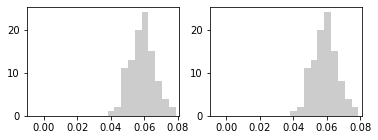

In [850]:
# jittertool.plot_beta_comparison(beta, plot_type=1)
# jittertool.plot_beta_comparison(beta, plot_type=2)
jittertool.plot_beta_comparison(beta, plot_type=3)

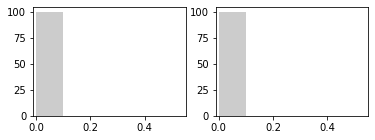

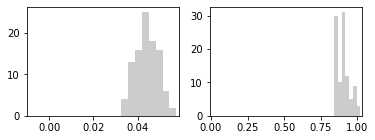

# Jitter multivariate data.

In [431]:
jittertool = jitter.JitterTool()

spk_bin_width = 0.002
jitter_window_width = 0.02

num_nodes = 3
synchrony_rate = 0.1
trial_length = 2
num_trials = 4
sync_prob_mat = np.array([[0,0.01,0.01], [0.01,0,0], [0.01,0,0]])

# lmbd = 20
# spike_times_multi = generator.generate_poisson_spike_times_multi_sync(lmbd, trial_length, num_nodes, num_trials, sync_prob_mat)

num_drivers, num_peaks, sigma = 2, 15, 0.04
spike_times_multi = generator.generate_amarasingham_spike_times_multi_sync(num_peaks, sigma,
        trial_length, num_nodes, num_trials, num_drivers, sync_prob_mat, sample_type='density', verbose=False)


[[array([0.10508286, 0.11757355, 0.13532004, 0.13736776, 0.15775476, 0.23964962, 0.33691176, 0.45504669,
         0.53603993, 0.58864977, 0.59301331, 0.6191489 , 0.70284502, 0.76438201, 0.77193471, 0.79476554,
         0.90705045, 1.35005744, 1.46824415, 1.53244127, 1.54631985, 1.55399055, 1.55629967, 1.56523859,
         1.61370146, 1.63819599, 1.63965454, 1.74178181, 1.75872308, 1.77016609, 1.79823991, 1.8226628 ,
         1.93399674, 1.94420849]),
  array([0.01180382, 0.03880396, 0.11575647, 0.16662497, 0.22847501, 0.35828728, 0.44779669, 0.45272611,
         0.51531308, 0.54414047, 0.85698119, 0.99769879, 1.04619416, 1.21212143, 1.29209727, 1.37143455,
         1.42366559, 1.51796008, 1.53545827, 1.56938729, 1.60315612, 1.71011268, 1.77317131, 1.77520758,
         1.80611756, 1.81967845, 1.84029535, 1.97281916]),
  array([0.08946924, 0.17863839, 0.19419914, 0.3623206 , 0.67901583, 0.81021704, 0.81733633, 0.90838732,
         1.01475785, 1.09128234, 1.12345142, 1.28155362, 1.4377893

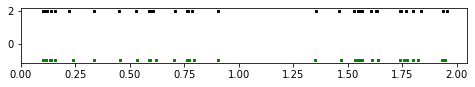

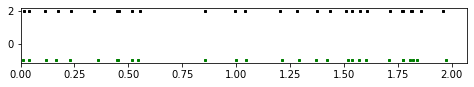

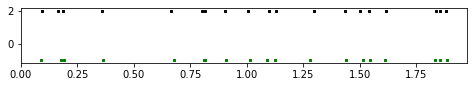

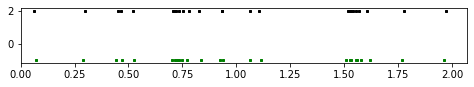

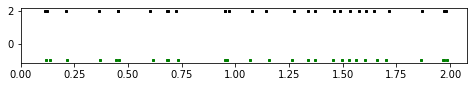

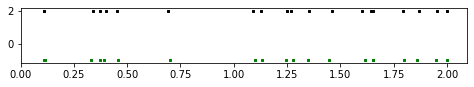

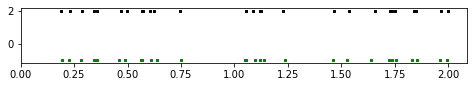

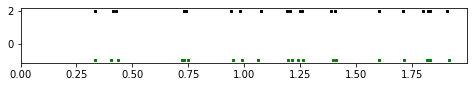

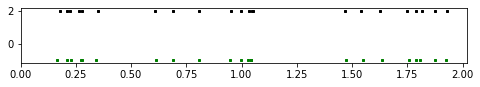

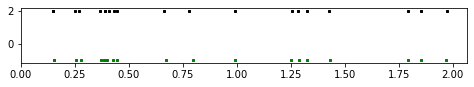

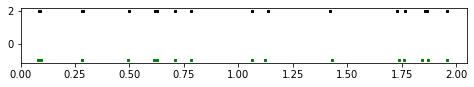

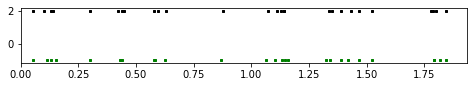

In [432]:
jittertool.jitter_spike_times_interval(spike_times_multi, jitter_window_width, num_jitter=1, data_dim=3, verbose=True)

# MC jitter multivariate regression. <a name='multi_regression'></a>

In [951]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
jittertool = jitter.JitterTool()

np.random.seed(3)
num_iters = 1
spk_bin_width = 0.002
jitter_window_width = 0.02
link_func = 'linear'
num_nodes = 3

beta = np.zeros([num_iters, 2, num_nodes-1])
p_values = np.zeros([num_iters, 2, num_nodes-1])

# for itr in tqdm(range(num_iters), ncols=100):
# for itr in trange(num_iters):
for itr in range(num_iters):
    trial_length = 2
    num_trials = 25
#     sync_prob_mat = np.array([[0,0.005,0.02], [0.005,0,0], [0.02,0,0]])
#     sync_prob_mat = np.array([[0,0.01,0.01], [0.01,0,0], [0.01,0,0]])
    sync_prob_mat = np.array([[0,0,0], [0,0,0], [1,1,0]])
#     sync_prob_mat = np.zeros([num_nodes, num_nodes])

    lmbd = [20, 20, 0.2]
    spike_times_multi = generator.generate_poisson_spike_times_multi_sync(lmbd, trial_length, num_nodes, num_trials,
        sync_prob_mat=sync_prob_mat, sync_rate_mat=None)
#     num_drivers, num_peaks, sigma = 2, 20, 0.04
#     spike_times_multi = generator.generate_amarasingham_spike_times_multi_sync(num_peaks, sigma,
#             trial_length, num_nodes, num_trials, num_drivers, sync_prob_mat, sample_type='density', verbose=False)

    distribution_type='mc'
    num_jitter=20
    basis_type = 'B1'
    p_values[itr,0], beta[itr,0] = jittertool.multivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_multi[1:], spike_times_multi[0], spk_bin_width, trial_length, jitter_window_width, link_func, 
        distribution_type, basis_type=basis_type, num_jitter=num_jitter, ci_alpha=0.05, verbose=False)


100%|█████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.55it/s]


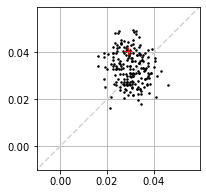

In [436]:
# Amarasingham. Null distribution. sync_prob_mat = np.array([[0,0,0], [0,0,0], [0,0,0]])

100%|█████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 11.08it/s]


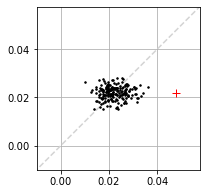

In [341]:
# Poisson. sync_prob_mat = np.array([[0,0.02,0.005], [0.02,0,0], [0.005,0,0]])

# Regression baseline removal.

In [655]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
jittertool = jitter.JitterTool()

# np.random.seed(2)
num_iters = 100
spk_bin_width = 0.002
jitter_window_width = 0.02
link_func = 'linear'
num_nodes = 5

beta = np.zeros([num_iters, 2, num_nodes-1])
p_values = np.zeros([num_iters, num_nodes-1])

for itr in tqdm(range(num_iters), ncols=100):
# for itr in trange(num_iters):
# for itr in range(num_iters):
    trial_length = 2
    num_trials = 25
    sync_prob_mat = jittertool.create_sync_prob_mat(num_nodes, [0.01, 0.03])
#     sync_prob_mat = jittertool.create_sync_prob_mat(num_nodes, [0,0])

#     lmbd = [10, 20, 40]
#     spike_times_multi = generator.generate_poisson_spike_times_multi_sync(lmbd, trial_length, num_nodes, num_trials, sync_prob_mat)
    num_drivers, num_peaks, sigma = 2, 20, 0.04
    spike_times_multi = generator.generate_amarasingham_spike_times_multi_sync(num_peaks, sigma,
            trial_length, num_nodes, num_trials, num_drivers, sync_prob_mat, sample_type='density', verbose=False)

    distribution_type='mc'
    num_jitter=100
    basis_type = 'B1'
    mean_correct = True

    p_values[itr], beta[itr,0] = jittertool.multivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_multi[1:], spike_times_multi[0], spk_bin_width, trial_length, jitter_window_width, link_func, 
        distribution_type, basis_type=basis_type, num_jitter=num_jitter, mean_correct=mean_correct, ci_alpha=0.05, verbose=0)

    jitter_type = 'interval'
    basis_type = 'B0B1'
    beta_tmp = jittertool.multivariate_spike_hist_coupling_filter_regression(
        spike_times_multi[1:], spike_times_multi[0], trial_length, spk_bin_width, jitter_window_width,
        jitter_type, basis_type, link_func=link_func, epsilon=1e-9)
    delta = int(jitter_window_width / spk_bin_width)
    beta[itr,1] = beta_tmp[:num_nodes-1,0] * (delta-1) / delta

100%|█████████████████████████████████████████████████████████████| 100/100 [17:02<00:00, 10.22s/it]


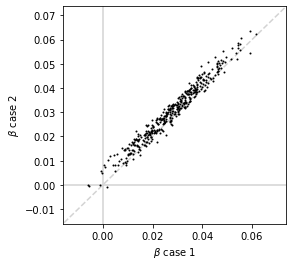

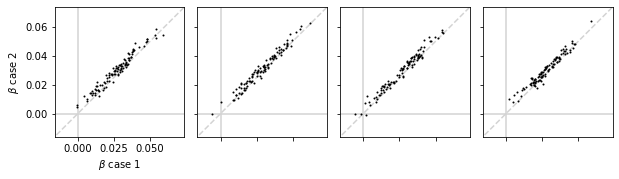

In [656]:
jittertool.plot_beta_comparison(beta, separate=False)
jittertool.plot_beta_comparison(beta, separate=True)

# Partial v.s. Marginal.

  0%|                                                                         | 0/1 [00:00<?, ?it/s]

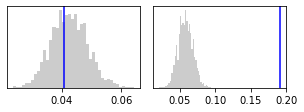

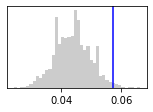

100%|████████████████████████████████████████████████████████████████| 1/1 [01:42<00:00, 102.29s/it]


In [1046]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
jittertool = jitter.JitterTool()

np.random.seed(2)
num_iters = 1
spk_bin_width = 0.002
jitter_window_width = 0.02
link_func = 'linear'
num_nodes = 3

beta = np.zeros([num_iters, 2, num_nodes-1])
p_values = np.zeros([num_iters, 2, num_nodes-1])

for itr in tqdm(range(num_iters), ncols=100):
# for itr in trange(num_iters):
# for itr in range(num_iters):
    trial_length = 2
    num_trials = 25
#     sync_prob_mat = jittertool.create_sync_prob_mat(num_nodes, [0.01, 0.03])
#     sync_prob_mat = jittertool.create_sync_prob_mat(num_nodes, [0,0])
#     sync_prob_mat = np.array([[0,0,0.02], [0,0,0.02], [0.02,0.02,0]])
    sync_prob_mat = np.array([[0,0,0], [0,0,0], [0.15,0.15,0]])
#     sync_rate_mat = np.array([[0,0,0.2], [0,0,0.2], [0.2,0.2,0]])

    lmbd = [20, 20, 10]
    spike_times_multi = generator.generate_poisson_spike_times_multi_sync(lmbd, trial_length, num_nodes, num_trials, 
            sync_prob_mat=sync_prob_mat, sync_rate_mat=None)
#     num_drivers, num_peaks, sigma = 2, 20, 0.04
#     spike_times_multi = generator.generate_amarasingham_spike_times_multi_sync(num_peaks, sigma, trial_length, num_nodes,
#             num_trials, num_drivers, sync_prob_mat=None, sync_rate_mat=sync_rate_mat,sample_type='density', verbose=False)

    distribution_type='mc'
    num_jitter=2000
    basis_type = 'B1'
    mean_correct = False

    # Partial regression.
    p_values[itr,0], beta[itr,0] = jittertool.multivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_multi[1:], spike_times_multi[0], spk_bin_width, trial_length, jitter_window_width, link_func, 
        distribution_type, basis_type=basis_type, num_jitter=num_jitter, mean_correct=mean_correct, ci_alpha=0.05, verbose=2)

    # Marginal regression.
    p_values[itr,1], beta[itr,1] = jittertool.multivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_multi[1:2], spike_times_multi[0], spk_bin_width, trial_length, jitter_window_width, link_func, 
        distribution_type, basis_type=basis_type, num_jitter=num_jitter, mean_correct=mean_correct, ci_alpha=0.05, verbose=2)

#     jitter_type = 'interval'
#     basis_type = 'B1'
#     beta_tmp = jittertool.multivariate_spike_hist_coupling_filter_regression(
#         spike_times_multi[1:], spike_times_multi[0], trial_length, spk_bin_width, jitter_window_width,
#         jitter_type, basis_type, link_func=link_func, epsilon=1e-9)
#     delta = int(jitter_window_width / spk_bin_width)
#     beta[itr,1] = beta_tmp[:num_nodes-1,0] * (delta-1) / delta
#     print(beta_tmp.T)

  0%|                                                                         | 0/1 [00:00<?, ?it/s]

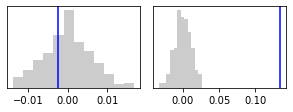

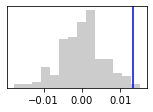

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.32s/it]


In [ ]:
jittertool.plot_p_value_distribution([p_values[:,0,0], p_values[:,0,1]], bin_width=0.05, ylim=[0, 4])
jittertool.plot_p_value_distribution([p_values[:,1,0]], bin_width=0.05, ylim=[0, 4])

In [ ]:
# jittertool.plot_beta_comparison(beta, plot_type=1)
# jittertool.plot_beta_comparison(beta, plot_type=2)
jittertool.plot_beta_comparison(beta, plot_type=3)
# jittertool.plot_beta_comparison(beta[:,:,[0]], plot_type=3)

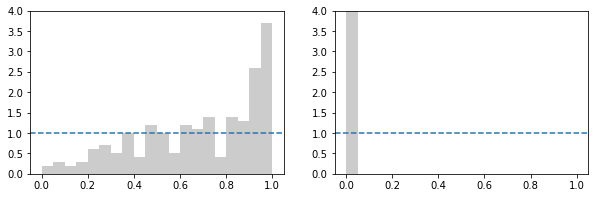

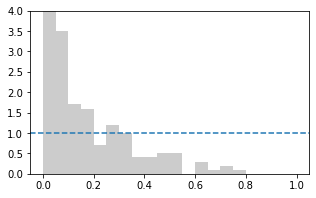

In [1040]:
# 20,20,10 Hz, p = 0.15